In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import re
import os
import csv
import copy
import json
import logging
from dataclasses import dataclass, field
from typing import Optional, Dict, Sequence, Tuple, List

import torch
import transformers
import sklearn
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import numpy as np
from torch.utils.data import Dataset
from scipy.special import softmax
from peft import (
    LoraConfig,
    AdaLoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    AdaLoraModel
)

In [108]:
from transformers import TrainerCallback, TrainerControl, TrainerState, TrainingArguments

class EvalAndSaveCallback(TrainerCallback):
    def __init__(self, trainer):
        self.trainer = trainer
        
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 500 == 0:
            results = self.trainer.evaluate()
            results_file = os.path.join(args.output_dir, f"results_step_{state.global_step}.json")
            output_file_path = os.path.join(args.output_dir, "results.csv")
            with open(results_file, "w") as f:
                json.dump(results, f)
            with open(output_file_path, "a", newline='') as csv_file:
                writer = csv.writer(csv_file)
        
                # Write keys (dictionary's keys) to the first row
                if state.global_step == 500:
                    writer.writerow(results.keys())

                # Write values in the subsequent rows
                writer.writerow(results.values())

In [109]:
@dataclass
class ModelArguments:
    #model_name_or_path: Optional[str] = field(default="zhihan1996/DNABERT-2-117M")
    model_name_or_path: Optional[str] = field(default="facebook/opt-125m")
    #model_name_or_path: Optional[str] = field(default="decapoda-research/llama-7b-hf")
    use_lora: bool = field(default=True, metadata={"help": "whether to use LoRA"})
    lora_r: int = field(default=8, metadata={"help": "hidden dimension for LoRA"})
    lora_alpha: int = field(default=32, metadata={"help": "alpha for LoRA"})
    lora_dropout: float = field(default=0.05, metadata={"help": "dropout rate for LoRA"})
    lora_target_modules: str = field(default="k_proj,q_proj,v_proj,fc1,fc2,output_proj", metadata={"help": "where to perform LoRA"})

In [110]:
@dataclass
class DataArguments:
    data_path: str = field(default="/common/zhanh/DNABERT_2/GUE/EMP/H3", metadata={"help": "Path to the training data."})
    kmer: int = field(default=-1, metadata={"help": "k-mer for input sequence. -1 means not using k-mer."})

In [111]:
import logging
logging.basicConfig(level=logging.ERROR)

@dataclass
class TrainingArguments(transformers.TrainingArguments):
    cache_dir: Optional[str] = field(default=None)
    run_name: str = field(default="run")
    optim: str = field(default="adamw_torch")
    model_max_length: int = field(default=512, metadata={"help": "Maximum sequence length."})
    gradient_accumulation_steps: int = field(default=1)
    per_device_train_batch_size: int = field(default=8)
    per_device_eval_batch_size: int = field(default=16)
    num_train_epochs: int = field(default=10)
    fp16: bool = field(default=False)
    logging_steps: int = field(default=1000)
    save_steps: int = field(default=500)
    eval_steps: int = field(default=500)
    evaluation_strategy: str = field(default="steps")
    load_best_model_at_end: bool = field(default=True)     # load the best model when finished training (default metric is loss)
    metric_for_best_model: str = field(default="matthews_correlation") # the metric to use to compare models
    greater_is_better: bool = field(default=True)           # whether the `metric_for_best_model` should be maximized or not
    logging_strategy: str = field(default="steps")  # Log every "steps"
    logging_steps: int = field(default=100)  # Log every 100 steps
    warmup_steps: int = field(default=50)
    weight_decay: float = field(default=0.01)
    learning_rate: float = field(default=1e-4)
    save_total_limit: int = field(default=10)
    load_best_model_at_end: bool = field(default=True)
    output_dir: str = field(default="/common/zhanh/DNABERT_2/output")
    find_unused_parameters: bool = field(default=False)
    checkpointing: bool = field(default=False)
    dataloader_pin_memory: bool = field(default=False)
    eval_and_save_results: bool = field(default=True)
    save_model: bool = field(default=False)
    seed: int = field(default=42)

In [112]:
def safe_save_model_for_hf_trainer(trainer: transformers.Trainer, output_dir: str):
    """Collects the state dict and dump to disk."""
    #state_dict = trainer.model.state_dict()
    if trainer.args.should_save:
        #cpu_state_dict = {key: value.cpu() for key, value in state_dict.items()}
        #del state_dict
        #trainer._save(output_dir, state_dict=cpu_state_dict)  # noqa
        checkpoint_dir = os.path.join(output_dir, f"checkpoint-{trainer.state.global_step}")
        trainer.model.save_pretrained(checkpoint_dir)
        trainer.model.config.save_pretrained(checkpoint_dir) 

In [113]:
def get_alter_of_dna_sequence(sequence: str):
    MAP = {"A": "T", "T": "A", "C": "G", "G": "C"}
    # return "".join([MAP[c] for c in reversed(sequence)])
    return "".join([MAP[c] for c in sequence])

"""
Transform a dna sequence to k-mer string
"""
def generate_kmer_str(sequence: str, k: int) -> str:
    """Generate k-mer string from DNA sequence."""
    return " ".join([sequence[i:i+k] for i in range(len(sequence) - k + 1)])


"""
Load or generate k-mer string for each DNA sequence. The generated k-mer string will be saved to the same directory as the original data with the same name but with a suffix of "_{k}mer".
"""
def load_or_generate_kmer(data_path: str, texts: List[str], k: int) -> List[str]:
    """Load or generate k-mer string for each DNA sequence."""
    kmer_path = data_path.replace(".csv", f"_{k}mer.json")
    if os.path.exists(kmer_path):
        logging.warning(f"Loading k-mer from {kmer_path}...")
        with open(kmer_path, "r") as f:
            kmer = json.load(f)
    else:        
        logging.warning(f"Generating k-mer...")
        kmer = [generate_kmer_str(text, k) for text in texts]
        with open(kmer_path, "w") as f:
            logging.warning(f"Saving k-mer to {kmer_path}...")
            json.dump(kmer, f)
        
    return kmer

In [114]:
class SupervisedDataset(Dataset):
    """Dataset for supervised fine-tuning."""

    def __init__(self, 
                 data_path: str, 
                 tokenizer: transformers.PreTrainedTokenizer, 
                 kmer: int = -1):

        super(SupervisedDataset, self).__init__()

        # load data from the disk
        with open(data_path, "r") as f:
            data = list(csv.reader(f))[1:]
        if len(data[0]) == 2:
            # data is in the format of [text, label]
            logging.warning("Perform single sequence classification...")
            texts = [d[0] for d in data]
            labels = [int(d[1]) for d in data]
        elif len(data[0]) == 3:
            # data is in the format of [text1, text2, label]
            logging.warning("Perform sequence-pair classification...")
            texts = [[d[0], d[1]] for d in data]
            labels = [int(d[2]) for d in data]
        else:
            raise ValueError("Data format not supported.")
        
        if kmer != -1:
            # only write file on the first process
            if torch.distributed.get_rank() not in [0, -1]:
                torch.distributed.barrier()

            logging.warning(f"Using {kmer}-mer as input...")
            texts = load_or_generate_kmer(data_path, texts, kmer)

            if torch.distributed.get_rank() == 0:
                torch.distributed.barrier()

        output = tokenizer(
            texts,
            return_tensors="pt",
            padding="longest",
            max_length=tokenizer.model_max_length,
            truncation=True,
        )

        self.input_ids = output["input_ids"]
        self.attention_mask = output["attention_mask"]
        self.labels = labels
        self.num_labels = len(set(labels))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [115]:
@dataclass
class DataCollatorForSupervisedDataset(object):
    """Collate examples for supervised fine-tuning."""

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.Tensor(labels).long()
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [116]:
def calculate_metric_with_sklearn(logits: np.ndarray, labels: np.ndarray):
    if logits.ndim == 3:
        # Reshape logits to 2D if needed
        logits = logits.reshape(-1, logits.shape[-1])
    predictions = np.argmax(logits, axis=-1)
    valid_mask = labels != -100  # Exclude padding tokens (assuming -100 is the padding token ID)
    valid_predictions = predictions[valid_mask]
    valid_labels = labels[valid_mask]
    # Compute probabilities from logits
    probabilities = softmax(logits, axis=-1)

    # Extract the probabilities corresponding to the positive class
    valid_scores = probabilities[valid_mask, 1]  # assuming the second column is the positive class
    return {
        "accuracy": sklearn.metrics.accuracy_score(valid_labels, valid_predictions),
        "f1": sklearn.metrics.f1_score(
            valid_labels, valid_predictions, average="macro", zero_division=0
        ),
        "matthews_correlation": sklearn.metrics.matthews_corrcoef(
            valid_labels, valid_predictions
        ),
        "precision": sklearn.metrics.precision_score(
            valid_labels, valid_predictions, average="macro", zero_division=0
        ),
        "recall": sklearn.metrics.recall_score(
            valid_labels, valid_predictions, average="macro", zero_division=0
        ),
        "pr_auc": average_precision_score(valid_labels, valid_scores),
        "roc_auc": roc_auc_score(valid_labels, valid_scores),
        "brier_score": brier_score_loss(valid_labels, valid_scores)
    }

In [117]:
"""
Compute metrics used for huggingface trainer.
""" 
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):  # Unpack logits if it's a tuple
        logits = logits[0]
    return calculate_metric_with_sklearn(logits, labels)

In [118]:
def train():
    #parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
    #print(parser)
    #model_args, data_args, training_args = parser.parse_args_into_dataclasses()
    parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments,))
    model_args, data_args, training_args, remaining = parser.parse_args_into_dataclasses(return_remaining_strings=True)

    # load tokenizer
    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_args.model_name_or_path,
        cache_dir=training_args.cache_dir,
        model_max_length=training_args.model_max_length,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )
    

    if "InstaDeepAI" in model_args.model_name_or_path:
        tokenizer.eos_token = tokenizer.pad_token

    # define datasets and data collator
    train_dataset = SupervisedDataset(tokenizer=tokenizer, 
                                      data_path=os.path.join(data_args.data_path, "train.csv"), 
                                      kmer=data_args.kmer)
    val_dataset = SupervisedDataset(tokenizer=tokenizer, 
                                     data_path=os.path.join(data_args.data_path, "dev.csv"), 
                                     kmer=data_args.kmer)
    test_dataset = SupervisedDataset(tokenizer=tokenizer, 
                                     data_path=os.path.join(data_args.data_path, "test.csv"), 
                                     kmer=data_args.kmer)
    data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

    #config = transformers.AutoConfig.from_pretrained(model_args.model_name_or_path, trust_remote_code=True)
    # load model
    model = transformers.AutoModelForSequenceClassification.from_pretrained(
        model_args.model_name_or_path,
        #config = config,
        cache_dir=training_args.cache_dir,
        num_labels=train_dataset.num_labels,
        trust_remote_code=True
    )
    #module_names = [name for name, _ in model.named_modules()]
    #print([(n, type(m)) for n, m in model.named_modules()])
    module_names_and_types = [(n, type(m)) for n, m in model.named_modules()]
    module = ",".join(n for n, _ in module_names_and_types)
    target = list(module.split(","))
    print(module)
    # Print the list
    #print(module_names)
    
    # Get the names of the layers in the base_model

    #for layer_idx, layer in enumerate(model.base_model.encoder.layer):
        #print(f"Layer {layer_idx}:")
    
        # Get the self-attention layer
        #self_attention_layer = layer.attention.self
    
        # Print the names of the sub-components
        #for name, module in self_attention_layer.named_children():
            #print(f"  {name}")

    # configure LoRA
    #model_args.lora_target_modules = r"bert\.encoder\.layer\.\d+\.mlp\.wo" 
    if model_args.use_lora:
        lora_config = AdaLoraConfig(
            r = model_args.lora_r,
            init_r = 12,
            target_r = 8,
            #target_modules=list(r"bert\.encoder\.layer\.\d+\.mlp\.wo"),
            lora_alpha=model_args.lora_alpha,
            target_modules=list(model_args.lora_target_modules.split(",")),
            #target_modules = target[1:],
            lora_dropout=model_args.lora_dropout,
            bias="none",
            task_type="SEQ_CLS",
            inference_mode=False,
            peft_type="ADALORA",
        )
        print(list(model_args.lora_target_modules.split(",")))
        model = get_peft_model(model, lora_config)
        #model = AdaLoraModel(model, lora_config, "default")
        model.print_trainable_parameters()


    # define trainer
    trainer = transformers.Trainer(model=model,
                                   tokenizer=tokenizer,
                                   args=training_args,
                                   compute_metrics=compute_metrics,
                                   train_dataset=train_dataset,
                                   eval_dataset=test_dataset,
                                   data_collator=data_collator,
                                  )

    callback = EvalAndSaveCallback(trainer)
    trainer.add_callback(callback)
    trainer.train()

    if training_args.save_model:
        trainer.save_state()
        safe_save_model_for_hf_trainer(trainer=trainer, output_dir=training_args.output_dir)

    # get the evaluation results from trainer
    if training_args.eval_and_save_results:
        results_path = os.path.join(training_args.output_dir, "results", training_args.run_name)
        print(results_path)
        results = trainer.evaluate(eval_dataset=test_dataset)
        os.makedirs(results_path, exist_ok=True)
        with open(os.path.join(results_path, "eval_results.json"), "w") as f:
            json.dump(results, f)
    
    # Get all checkpoint directories
#     if training_args.eval_and_save_results:
#     # Get list of all checkpoints
#         checkpoints = [dir_name for dir_name in os.listdir(training_args.output_dir) 
#                    if 'checkpoint' in dir_name]
    
#         for checkpoint in checkpoints:
#             checkpoint_path = os.path.join(training_args.output_dir, checkpoint)
        
#         # Load model from checkpoint
#             model_checkpoint = transformers.AutoModelForSequenceClassification.from_pretrained(checkpoint_path,trust_remote_code=True)
#             trainer.model = model_checkpoint  # Update trainer's model
#             print(model.device)
#             print(next(model.parameters()).device)
#             for key, value in inputs.items():
#                 if isinstance(value, torch.Tensor):
#                     print(f"{key} is on {value.device}")
#             #print(labels.device)
#             device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#             input_ids = input_ids.to(device)
#             token_type_ids = token_type_ids.to(device)
#             attention_mask = attention_mask.to(device)

#             results = trainer.evaluate(eval_dataset=test_dataset)
        
#         # Modify results_path to include checkpoint name
#             results_path = os.path.join(training_args.output_dir, "results", checkpoint)
#             os.makedirs(results_path, exist_ok=True)
        
#             with open(os.path.join(results_path, "eval_results.json"), "w") as f:
#                 json.dump(results, f)

In [119]:
#parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
#parser.parse_args_into_dataclasses()

parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments,))
model_args, data_args, training_args, remaining = parser.parse_args_into_dataclasses(return_remaining_strings=True)
print(training_args)

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
cache_dir=None,
checkpointing=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=False,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_and_save_results=True,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
find_unused_parameters=False,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,

In [120]:
if __name__ == "__main__":
    train()

Some weights of the model checkpoint at facebook/opt-125m were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,model,model.decoder,model.decoder.embed_tokens,model.decoder.embed_positions,model.decoder.final_layer_norm,model.decoder.layers,model.decoder.layers.0,model.decoder.layers.0.self_attn,model.decoder.layers.0.self_attn.k_proj,model.decoder.layers.0.self_attn.v_proj,model.decoder.layers.0.self_attn.q_proj,model.decoder.layers.0.self_attn.out_proj,model.decoder.layers.0.activation_fn,model.decoder.layers.0.self_attn_layer_norm,model.decoder.layers.0.fc1,model.decoder.layers.0.fc2,model.decoder.layers.0.final_layer_norm,model.decoder.layers.1,model.decoder.layers.1.self_attn,model.decoder.layers.1.self_attn.k_proj,model.decoder.layers.1.self_attn.v_proj,model.decoder.layers.1.self_attn.q_proj,model.decoder.layers.1.self_attn.out_proj,model.decoder.layers.1.activation_fn,model.decoder.layers.1.self_attn_layer_norm,model.decoder.layers.1.fc1,model.decoder.layers.1.fc2,model.decoder.layers.1.final_layer_norm,model.decoder.layers.2,model.decoder.layers.2.self_attn,model.decoder.layers.2.self_

Step,Training Loss,Validation Loss,Accuracy,F1,Matthews Correlation,Precision,Recall,Pr Auc,Roc Auc,Brier Score
500,0.673800,0.653619,0.616566,0.599038,0.261908,0.644804,0.618429,0.695225,0.705011,0.230094
1000,0.552000,0.537415,0.752171,0.751461,0.508773,0.756093,0.752692,0.788945,0.823190,0.176058
1500,0.496700,0.498861,0.778891,0.778486,0.561116,0.781800,0.779321,0.813344,0.852489,0.160530
2000,0.504200,0.513311,0.778891,0.776588,0.566930,0.788966,0.778068,0.818701,0.855679,0.159359
2500,0.451400,0.490363,0.793587,0.793569,0.587139,0.793573,0.793566,0.829423,0.863887,0.150390
3000,0.423300,0.479459,0.800935,0.799951,0.606021,0.805657,0.800386,0.840951,0.868501,0.147289
3500,0.463800,0.498473,0.802271,0.801800,0.608932,0.806186,0.802755,0.851196,0.874715,0.150542
4000,0.398700,0.440212,0.819639,0.819461,0.639770,0.820342,0.819428,0.865784,0.881496,0.135591
4500,0.471100,0.457574,0.812291,0.811077,0.630581,0.818967,0.811656,0.865251,0.886605,0.137618
5000,0.415500,0.432217,0.829659,0.829616,0.659321,0.829738,0.829583,0.873365,0.892712,0.129114


/common/zhanh/DNABERT_2/output/results/run


    eval_loss  eval_accuracy   eval_f1  eval_matthews_correlation  \
0    0.653619       0.616566  0.599038                   0.261908   
1    0.537415       0.752171  0.751461                   0.508773   
2    0.498861       0.778891  0.778486                   0.561116   
3    0.513311       0.778891  0.776588                   0.566930   
4    0.490363       0.793587  0.793569                   0.587139   
5    0.479459       0.800935  0.799951                   0.606021   
6    0.498473       0.802271  0.801800                   0.608932   
7    0.440212       0.819639  0.819461                   0.639770   
8    0.457574       0.812291  0.811077                   0.630581   
9    0.432217       0.829659  0.829616                   0.659321   
10   0.469584       0.814963  0.814100                   0.637947   
11   0.460452       0.816967  0.815086                   0.644404   
12   0.442386       0.815631  0.815631                   0.631447   
13   0.427470       0.828991  0.82

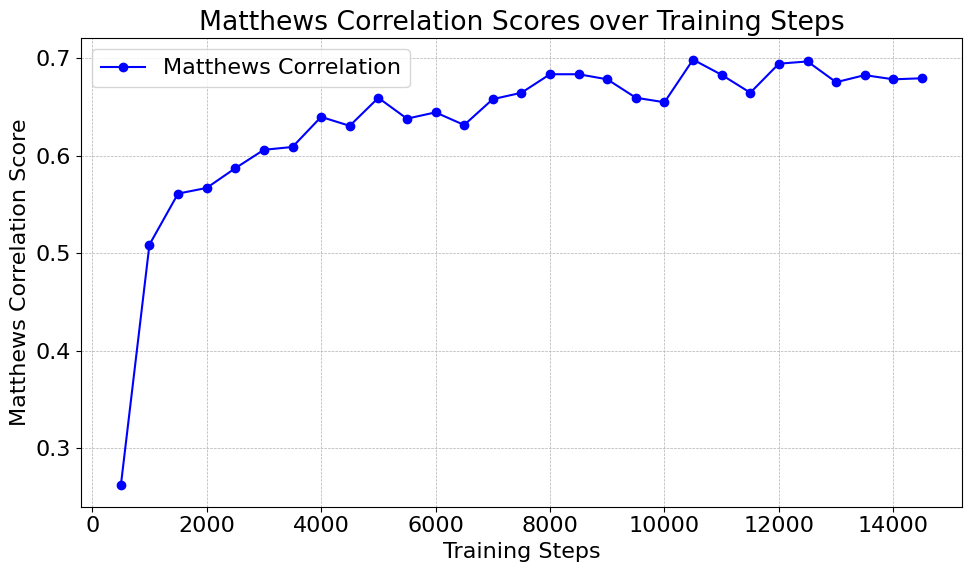

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the data from the CSV file
file_path = '/common/zhanh/DNABERT_2/output/results.csv'  # replace with your file path
df = pd.read_csv(file_path)
print(df)
# Extract Matthews Correlation scores and steps
# Create the 'Step' column
df['Step'] = np.arange(500, 500 * (len(df) + 1), 500)

# Extract Matthews Correlation scores and steps
steps = df['Step'].values
matthews_scores = df['eval_matthews_correlation'].values



# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, matthews_scores, marker='o', color='b', label='Matthews Correlation')
plt.xlabel('Training Steps')
plt.ylabel('Matthews Correlation Score')
plt.title('Matthews Correlation Scores over Training Steps')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

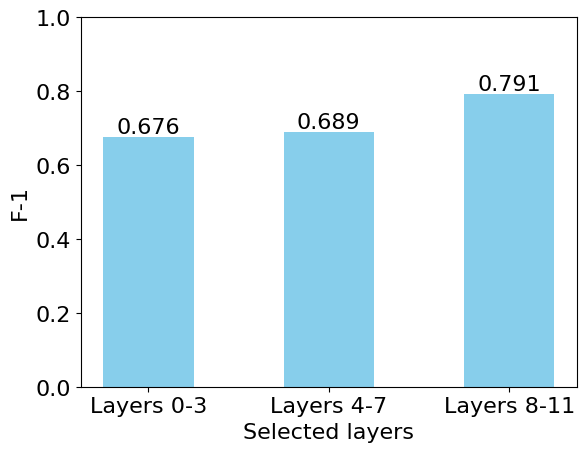

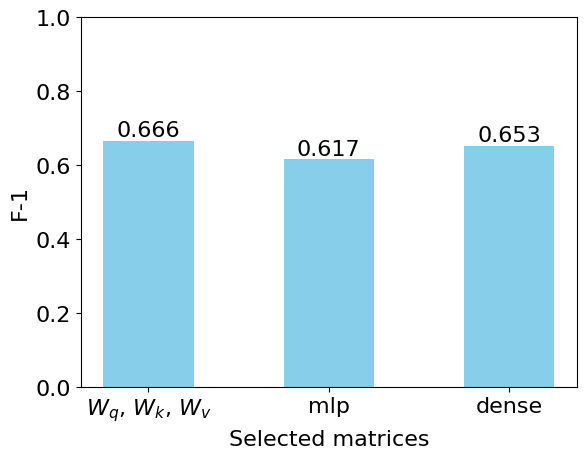

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'input_ids': tensor([[ 101, 2023, 2003, 1037, 7099, 6251, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[[ 1.3630e-02, -2.6490e-02, -2.3503e-02,  ...,  8.6805e-03,
           7.1340e-03,  1.5147e-02],
         [-5.7095e-02,  1.5283e-02, -4.6868e-03,  ..., -3.2484e-03,
           9.7317e-05,  9.4175e-03],
         [-3.6044e-02, -2.4606e-02, -2.5735e-02,  ...,  3.3691e-03,
          -1.8300e-03,  2.6855e-02],
         ...,
         [ 3.2079e-02,  6.3135e-03, -6.4352e-03,  ..., -1.1689e-03,
          -1.0810e-01, -8.9524e-02],
         [-2.0745e-02, -1.9870e-03, -1.1789e-02,  ...,  1.2760e-02,
           2.0031e-02,  2.5873e-02],
         [-1.4521e-02, -9.9615e-03,  6.0263e-03,  ..., -2.5035e-02,
           4.6379e-03, -1.5378e-03]]], grad_fn=<EmbeddingBackward0>)
